In [293]:
# Change this variable to switch between model 0 and model 1 bubblesheets
bubble_sheet_model = 0

In [294]:
import os
import cv2
import xlsxwriter
import numpy as np
from matplotlib import pyplot as plt
import imutils
from imutils import contours

In [295]:
num_questions = [50, 20]
num_answers = 5
answers_block_height = [450, 750]
answers_block_width = [190, 300]
bubble_dimension = [26, 40]
num_answers_blocks = num_questions[bubble_sheet_model] // 10

In [296]:
# Show the figures / plots inside the notebook
def show_images(images, titles=None):
       # This function is used to show image(s) with titles by sending an array of images 
       # and an array of associated titles.
       # images[0] will be drawn with the title titles[0] if exists
       n_ims = len(images)
       if titles is None:
              titles = ['(%d)' % i for i in range(1, n_ims + 1)]
       fig = plt.figure()
       n = 1
       for image, title in zip(images, titles):
              a = fig.add_subplot(1, n_ims, n)
              if image.ndim == 2:
                     plt.gray()
              plt.imshow(image)
              a.set_title(title)
              n += 1
       fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
       plt.show()

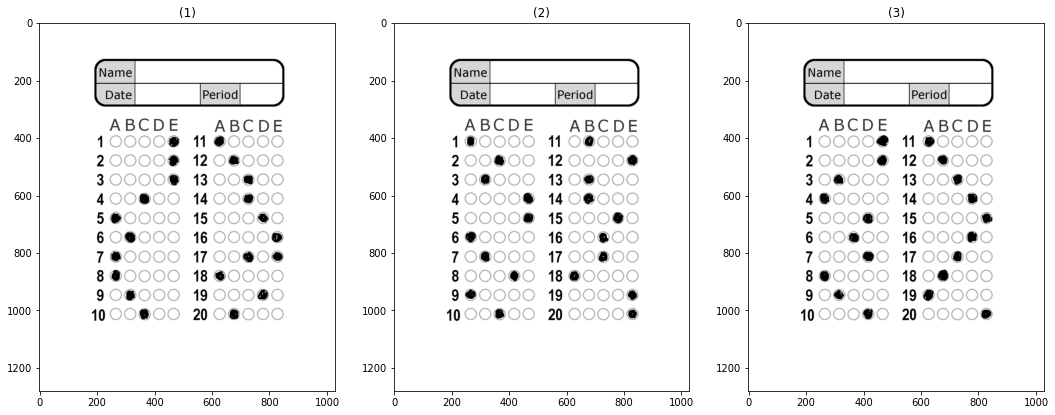

In [297]:
exam_papers_dir = os.path.dirname(os.path.realpath('__file__'))
exam_papers_dir = os.path.join(exam_papers_dir, 'model_' + str(bubble_sheet_model) + '\\')
exam_papers_images = os.listdir(exam_papers_dir)
exam_papers = []
for i in range (0, len(exam_papers_images)):
       exam_papers.append(cv2.cvtColor(cv2.imread(exam_papers_dir + exam_papers_images[i]), cv2.COLOR_BGR2GRAY))
show_images(exam_papers)
num_exams = len(exam_papers)

In [298]:
model_answer_path = os.path.dirname(os.path.realpath('__file__'))
model_answer_path = os.path.join(model_answer_path, 'model_answer_' + str(bubble_sheet_model) + '.txt')
model_answer_file = open(model_answer_path, 'r')
answer_key = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4}
model_answer = model_answer_file.read().splitlines()
for i in range(0, len(model_answer)):
       model_answer[i] = answer_key[model_answer[i]]

In [299]:
template = cv2.imread('template.jpeg')
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
template = cv2.Canny(template, 50, 200)
(template_height, template_width) = template.shape[:2]

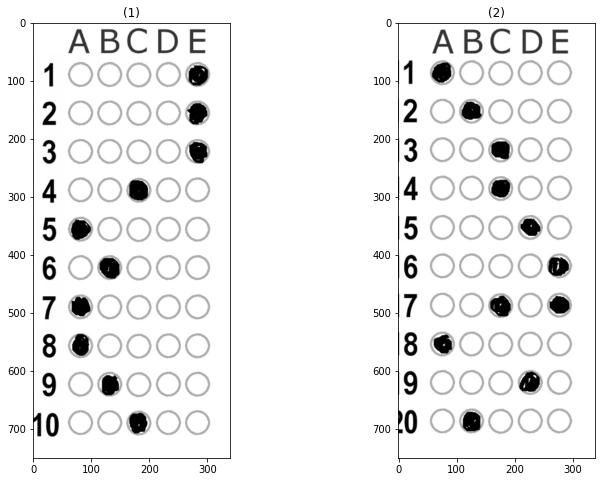

In [300]:
# The size of the template is not the same in the two exam models
# Using cv2.matchTemplate requires that size of the template image and the size of the template in the original image must be the same
# The solution of this problem is to loop over the original image at multiple scales while applying matchTemplate
# After looping over all scales of the image, take the region with maximum correlation coefficient
 
def get_answers_blocks():
       blocks = []
       for i in range (0, num_exams):
              gray_image = exam_papers[i].copy()
              temp = []
              for j in range (0, num_answers_blocks):
                     found = None
                     # Start from 10% of the size of the original image upto 100%(original resolution)
                     for scale in np.linspace(0.1, 1.0, 20)[::-1]:
                            # resize the image according to the scale, and keep track of the ratio of the resizing
                            resized_image = imutils.resize(gray_image, width = int(gray_image.shape[1] * scale))
                            r = gray_image.shape[1] / float(resized_image.shape[1])

                            # if the resized image is smaller than the template, then break from the loop
                            if resized_image.shape[0] < template_height or resized_image.shape[1] < template_width:
                                   break

                            edged_image = cv2.Canny(resized_image, 50, 200)
                            result = cv2.matchTemplate(edged_image, template, cv2.TM_CCOEFF)
                            
                            # Find the min and max correlation results and their positions
                            (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

                            if found is None or maxVal > found[0]:
                                   found = (maxVal, maxLoc, r)

                     (_, maxLoc, r) = found
                     (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))

                     temp.append(gray_image[startY:startY + answers_block_height[bubble_sheet_model], 
                                 startX - 40:startX + answers_block_width[bubble_sheet_model]].copy())
                     
                     # Make the matched image black inorder not to match it once again            
                     gray_image[startY:startY + answers_block_height[bubble_sheet_model], 
                                startX - 40:startX + answers_block_width[bubble_sheet_model]] = 0
              blocks.append(temp)
       return blocks

answers_blocks = get_answers_blocks()
show_images(answers_blocks[0])

In [301]:
# Thresholding the block answers found from the previous step
def get_thresholded_answers_blocks():
       thresh = []
       for i in range (0, num_exams):
              temp = []
              for j in range (0, num_answers_blocks):
                     temp.append(cv2.threshold(answers_blocks[i][j], 220, 255, cv2.THRESH_BINARY_INV)[1])
              thresh.append(temp)
       return thresh
       
thresholded_answers_blocks = get_thresholded_answers_blocks()

In [302]:
# The following function finds the ID of each student 
# Note that model_1 has no section for student IDs, so the IDs in this model is a dummy list
def get_students_ids():
       student_id_map = {0 : 0, 1 : 9, 2 : 8, 3 : 7, 4 : 6, 5 : 5, 6 : 4, 7 : 3, 8 : 2, 9 : 1}
       temp_ids = []
       
       for i in range (0, num_exams):
              thresholded_answers_blocks[i].insert(0, thresholded_answers_blocks[i][4])
              del thresholded_answers_blocks[i][5]
              student_id = exam_papers[i][250:670, 200:400].copy()
              student_id = cv2.threshold(student_id, 220, 255, cv2.THRESH_BINARY_INV)[1]
              m = cv2.findContours(student_id.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
              m = imutils.grab_contours(m)
              student_id_cnts = []
              
              for c in m:
                     # compute the bounding box of the contour, then use the bounding box to derive the aspect ratio                                       
                     (x, y, w, h) = cv2.boundingRect(c)
                     ar = w / float(h)

                     # check if the contour is an answer circle using the dimension of the circle and it should have an aspect ratio approximately equal to 1
                     if w >= bubble_dimension[bubble_sheet_model] and h >= bubble_dimension[bubble_sheet_model] and ar >= 0.9 and ar <= 1.1:
                            student_id_cnts.append(c)
              
              cv2.drawContours(student_id, student_id_cnts, -1, (255, 255, 255), 1)
              # show_images([student_id])
              # Sort the bubbles' contours from left to right because each column of bubbles is a digit in the student ID 
              student_id_cnts = contours.sort_contours(student_id_cnts, method='left-to-right')[0]

              IDs = []
              for (q, k) in enumerate(np.arange(0, len(student_id_cnts), 10)):             
                     # sort the contours of each column of bubbles from bottom to top and then use the ma defined above to map the choosen bubble with the correct digit
                     cnts = contours.sort_contours(student_id_cnts[k:k + 10], method='bottom-to-top')[0]
                     bubbled = None

                     for (m, c) in enumerate(cnts):
                            # Create a mask that reveals only the current bubble
                            mask = np.zeros(student_id.shape, dtype='uint8')
                            
                            # Draw the contours of each bubble on the mask
                            # The value -1 in the thickness parameter indicates filling the contours with the color
                            cv2.drawContours(mask, [c], -1, 255, -1)
                            
                            # apply the mask to the thresholded image, then count the number of non-zero pixels in the bubble area
                            mask = cv2.bitwise_and(student_id, student_id, mask=mask)
                            total = cv2.countNonZero(mask)

                            if bubbled is None or total > bubbled[0]:
                                   bubbled = (total, m)
                     IDs.append(student_id_map[bubbled[1]])      

              # Convert the digits found from the bubbles into a string
              temp_id = ''
              for i in range (0, 5):
                     temp_id = temp_id + str(IDs[i])
              temp_ids.append(temp_id)

       return temp_ids


if bubble_sheet_model == 0:
       id_choices = get_students_ids()
else: 
       id_choices = list(range(0, num_exams))

In [303]:
def get_answers_contours():
       cnts = []
       for i in range (0, num_exams):
              exam_paper_cnts = []
              for j in range (0, num_answers_blocks):
                     # Finding the contours of the asnwers' circles inorder to check which one is choosen
                     m = cv2.findContours(thresholded_answers_blocks[i][j].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                     m = imutils.grab_contours(m)
                     
                     answers_cnts = []
                     for c in m:
                            # compute the bounding box of the contour, then use the bounding box to derive the aspect ratio
                            (x, y, w, h) = cv2.boundingRect(c)
                            ar = w / float(h)
                            
                            # check if the contour is an answer circle using the dimension of the circle and it should have an aspect ratio approximately equal to 1
                            if w >= bubble_dimension[bubble_sheet_model] and h >= bubble_dimension[bubble_sheet_model] and ar >= 0.9 and ar <= 1.1:
                                   answers_cnts.append(c)
                     exam_paper_cnts.append(answers_cnts)
              cnts.append(exam_paper_cnts)
       return cnts

answers_contours = get_answers_contours()

In [304]:
def get_students_answers():
       answers = []
       for i in range (0, num_exams):
              student_answers = []
              for j in range (0, num_answers_blocks):
                     # Sort the contours for each answers block from top to bottom so that the contours are sorted row by row (where each row corresponds to an answer for a question)
                     answers_contours[i][j] = contours.sort_contours(answers_contours[i][j], method='top-to-bottom')[0]
                     
                     block_answers = []     
                     for (q, k) in enumerate(np.arange(0, len(answers_contours[i][j]), num_answers)):
                            # Sort the contours for the current answer from left to right
                            cnts = contours.sort_contours(answers_contours[i][j][k:k + num_answers], method='left-to-right')[0]
                            
                            bubbled = None
                            # Iterate over the sorted answer bubbles
                            for (m, c) in enumerate(cnts):
                                   # Create a mask that reveals only the current answer bubble
                                   mask = np.zeros(thresholded_answers_blocks[i][j].shape, dtype='uint8')

                                   # Draw the contours of each bubble on the mask
                                   # The value -1 in the thickness parameter indicates filling the contours with the color
                                   cv2.drawContours(mask, [c], -1, 255, -1)
                                   
                                   # apply the mask to the thresholded image, then count the number of non-zero pixels in the bubble area
                                   mask = cv2.bitwise_and(thresholded_answers_blocks[i][j], thresholded_answers_blocks[i][j], mask=mask)
                                   
                                   # Count the total number of non-zero pixels after applying the mask
                                   # The bubble with the maximum total value is the choice of the student
                                   total = cv2.countNonZero(mask)
                                   
                                   if bubbled is None or total > bubbled[0]:
                                          bubbled = (total, m)
                            block_answers.append(bubbled[1])     
                     student_answers.append(block_answers)
              answers.append(student_answers)
       return answers
students_answers = get_students_answers()


In [305]:
# The following function merges the answers of all exam blocks in one list
def merge_answers_blocks():
       merged_answers = []
       for i in range (0, num_exams):
              student_answers = []
              for j in range (0, num_answers_blocks):
                    student_answers = student_answers + students_answers[i][j]
              merged_answers.append(student_answers)
       return merged_answers
students_answers = merge_answers_blocks()

In [306]:
# The following function marks the all the exams according to the model answer which is read from an input file
def mark_exams():
       grades = []
       for i in range (0, num_exams):
              student_grades = []
              for j in range (0, num_questions[bubble_sheet_model]):
                     student_grades.append(int(students_answers[i][j] == model_answer[j]))
              grades.append(student_grades)
       return grades
grades = mark_exams()

In [307]:
# The following code exports the output to an excel file
grades_file = xlsxwriter.Workbook('model_' +  str(bubble_sheet_model) + '_results' + '.xlsx')
grades_sheet = grades_file.add_worksheet('grades')
cell_format = grades_file.add_format()
cell_format.set_align('center')

grades_sheet.write(0, 0, 'ID', cell_format)
for i in range (0, num_exams):
       grades_sheet.write(i + 1, 0, int(id_choices[i]), cell_format)

for i in range (0, num_questions[bubble_sheet_model]):
       grades_sheet.write(0, i + 1, 'Q' + str(i + 1), cell_format)
for i in range (0, num_exams):
       for j in range(0, num_questions[bubble_sheet_model]):
              grades_sheet.write(i + 1, j + 1, grades[i][j], cell_format)

grades_file.close()